In [2]:
from langgraph.graph import StateGraph, START, END
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from typing import TypedDict, List, Annotated
import operator

import os
from dotenv import load_dotenv
load_dotenv()


# Cricket Stats calculate

True

In [3]:
# Model 

repo_id = "meta-llama/Llama-3.1-8B-Instruct"
# repo_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
endpoint = HuggingFaceEndpoint(
            repo_id= repo_id,
            max_new_tokens= 128,
            temperature= 0.3,
            task="text-generation",
            huggingfacehub_api_token= os.getenv('HUGGINGFACEHUB_API_TOKEN'))
llm = ChatHuggingFace(llm= endpoint)

e:\AI-LLMs\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# State

class EssayState(TypedDict):
    essay : str
    clarity : str
    depth : str
    language : str
    final_feedback : str
    # For indivual scores we can define custom reducer function 
    # or for listappend use "add" from "operator" library,
    # Note that [1,2] + [3] is right not [1,2] + [3]. Hence 
    # each node must return list, which + operator can merge
    # into 1 final list.
    individual_scores : Annotated[ List[int], operator.add]
    final_score : str

# Parallel Node Structure
    
# class LLMOutput(BaseModel): 
#     feedback : str =  Field(description="Analyze the essay and write feedback on its clarity of thought")
#     score : int =  Field(description="Analyze the essay and give score(out of 10) on its clarity of thought")
# But Some llama models dont support pydantic model for 
# structured output, We can use TypedDict
    
class LLMOutput(TypedDict):
    feedback : str
    score : int

class SummerizeOutput(TypedDict):
    feedback : str

In [19]:
# Testing Parsers and Models
essay_text= """ You Cannot Shake Hands with a Clenched Fist : 
            In a world increasingly shaped by complex divisions: political, ethnic, economic, or ideological, Indira Gandhi’s statement, “You cannot shake hands with a clenched fist,” remains strikingly relevant. The metaphor represents a universal truth: sustainable peace cannot emerge from hostility. This essay will examine historical precedents, contemporary challenges, and policy-driven solutions to argue that dialogue is indispensable for lasting peace.  

            At its core, the metaphor speaks to the emotional and psychological barriers to peace. A clenched fist reflects fear, anger, and defensiveness; traits that often escalate rather than resolve conflict. By contrast, the gesture of a handshake implies mutual recognition and a desire to coexist. In both personal and political arenas, real progress begins only when parties choose communication over coercion. Such psychological barriers manifest as geopolitical conflicts, underscoring the urgency of diplomatic engagement, as history repeatedly demonstrates. 

            History provides numerous instances where diplomacy played a decisive role in averting large-scale disasters. During the Cold War, despite intense ideological divisions, diplomacy played a vital role in maintaining a balance of power. The Cuban Missile Crisis of 1962, resolved through direct communication between Washington and Moscow, is frequently cited as a moment when dialogue triumphed over destruction. Likewise, the post-World War II formation of multilateral institutions like the United Nations and the European Union reflected a collective recognition of the necessity for rules-based international cooperation. More recently, the Iran Nuclear Deal (2015) showcased the potential, albeit fragile, of multilateral diplomacy to curb proliferation. Agreements such as the Paris Climate Accord, though often imperfect or critiqued,  institutionalize dialogue, creating platforms for incremental progress.  

            While the ideals of diplomacy and cooperation are widely supported in principle, real-world applications are fraught with difficulty. Historical grievances, asymmetrical power dynamics, and political opportunism often obstruct genuine negotiation. The ongoing conflict between Israel and Palestine illustrates how entrenched distrust, competing historical narratives, and cycles of violence undermine diplomatic efforts. Despite repeated international initiatives, a durable peace remains elusive. In another instance, the 2021 withdrawal of U.S. forces from Afghanistan exposed the limitations of prolonged military engagement without parallel political reconciliation. The eventual negotiations, though contentious, reaffirm that even adversaries must eventually embrace dialogue. """

prompt = f""" You are an essay writing assistant. Analyze the essay and give feedback on clarity of thought (single string)
             and score(out of 10). essay : {essay_text}"""

structured_llm = llm.with_structured_output(LLMOutput)
response = structured_llm.invoke(prompt)
print(response)

{'feedback': 'The essay clearly develops the idea that dialogue is essential for lasting peace, supported by historical and contemporary examples, but could benefit from more nuanced analysis of counterarguments and potential challenges to diplomatic engagement.', 'score': 8}


In [20]:
response["score"]

8

In [21]:
# Nodes/functions

def llm_clarity(state : EssayState)-> EssayState:
    essay_text = state["essay"]
    prompt = f""" You are an essay writing assistant. Analyze the essay and give feedback on clarity of thought (single string)
             and score(out of 10). essay : {essay_text}"""

    structured_llm = llm.with_structured_output(LLMOutput)
    response = structured_llm.invoke(prompt)
    # Make sure to give score in a list, not single int
    # See State TypedDict Annotated for details.
    partial_state = { "clarity": response["feedback"],
                      "individual_scores":[response["score"] ]}
    return partial_state

def llm_depth(state : EssayState)-> EssayState:
    essay_text = state["essay"]
    prompt = f""" You are an essay writing assistant. Analyze the essay and give feedback on depth of analysis (single string)
             and score(out of 10). essay : {essay_text}"""
    
    structured_llm = llm.with_structured_output(LLMOutput)
    response = structured_llm.invoke(prompt)
    partial_state = {   
                        "depth":  response["feedback"],
                        "individual_scores": [response["score"]]
                    }
    return partial_state

def llm_language(state : EssayState)-> EssayState:
    essay_text = state["essay"]
    prompt = f""" You are an essay writing assistant. Analyze the essay and give feedback on language & grammar (single string)
             and score(out of 10). essay : {essay_text}"""
    
    structured_llm = llm.with_structured_output(LLMOutput)
    response = structured_llm.invoke(prompt)
    partial_state = {
        "language": response["feedback"],
        "individual_scores": [response["score"]]
    }
    return partial_state

def summarize(state : EssayState)-> EssayState:
    clarity = state["clarity"]
    depth = state["depth"]
    language = state["language"]
    prompt = f""" You are an essay writing assistant. Given 
                previous feedbacks on clarity of thought , depth 
                of analysis, languange and grammar of an essay, 
                You need to professionally summerize these feedbacks
                into a single feedback (single string).
                clarity of thought : {clarity},
                depth of analysis : {depth},
                Language and grammar : {language}"""

    structured_llm = llm.with_structured_output(SummerizeOutput)
    response = structured_llm.invoke(prompt)
    
    final_score = float(sum(state["individual_scores"])) / 3
    partial_state = {
        "final_feedback": response["feedback"],
        "final_score": final_score
    }
    return partial_state

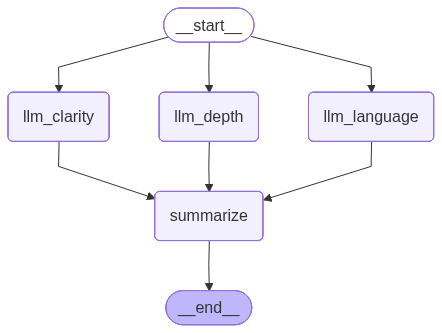

In [22]:
# Graph 

graph = StateGraph(state_schema= EssayState)

graph.add_node("llm_clarity", llm_clarity)
graph.add_node("llm_depth", llm_depth)
graph.add_node("llm_language", llm_language)
graph.add_node("summarize", summarize)

# Adding parallel edges
graph.add_edge(START, "llm_clarity")
graph.add_edge(START, "llm_depth")
graph.add_edge(START, "llm_language")

# Adding aggregate edges
graph.add_edge("llm_clarity","summarize")
graph.add_edge("llm_depth","summarize")
graph.add_edge("llm_language","summarize")

graph.add_edge("summarize", END)

workflow = graph.compile()
workflow

In [23]:
essay = """Essay Topic: The Impact of Technology on Education

Technology are changing education in many way, some is good and some is not so much good. Student using computer and phones for study but many time they distracted by social media and games which make the learning go down. Before, people going library and reading book, now they just typing in google and copy paste without understand real knowledge.

Teacher also feeling confuse because student not listening in class, they think everything is online so why listen. But teacher still important because technology cannot give emotion or encouragement like human does, but still some peoples saying AI will replace all teachers in future. This make worry and also hope because maybe education become cheaper but maybe it become boring machine style.

Another problem is internet not same everywhere. In city student can learning with fast wifi, but in village many no connection, so they left behind. This is unfair and technology promise equality but actually sometimes it make more gap between rich and poor student.

Also online learning have issue, many student don’t open camera and they sleeping or doing nothing, but teacher cannot know. So quality of education going down. Even if technology is fast, the brain of student not become fast automatic.

In conclusion, technology and education is link together strong, but still many problem happening. Future maybe bright or maybe dark, depend how peoples using it. If we only trust computer, maybe human thinking will become weak, but if we use wisely then maybe education become more powerful than ever in history. """

init_state = {
  "essay": essay
}
init_state

{'essay': 'Essay Topic: The Impact of Technology on Education\n\nTechnology are changing education in many way, some is good and some is not so much good. Student using computer and phones for study but many time they distracted by social media and games which make the learning go down. Before, people going library and reading book, now they just typing in google and copy paste without understand real knowledge.\n\nTeacher also feeling confuse because student not listening in class, they think everything is online so why listen. But teacher still important because technology cannot give emotion or encouragement like human does, but still some peoples saying AI will replace all teachers in future. This make worry and also hope because maybe education become cheaper but maybe it become boring machine style.\n\nAnother problem is internet not same everywhere. In city student can learning with fast wifi, but in village many no connection, so they left behind. This is unfair and technology 

In [24]:
final_state = workflow.invoke(init_state)

print(final_state["final_feedback"])

The essay requires significant improvement in terms of clarity of thought, depth of analysis, and language/grammar, with a lack of concrete examples and evidence, informal tone, and grammatical errors.


In [26]:
final_state

{'essay': 'Essay Topic: The Impact of Technology on Education\n\nTechnology are changing education in many way, some is good and some is not so much good. Student using computer and phones for study but many time they distracted by social media and games which make the learning go down. Before, people going library and reading book, now they just typing in google and copy paste without understand real knowledge.\n\nTeacher also feeling confuse because student not listening in class, they think everything is online so why listen. But teacher still important because technology cannot give emotion or encouragement like human does, but still some peoples saying AI will replace all teachers in future. This make worry and also hope because maybe education become cheaper but maybe it become boring machine style.\n\nAnother problem is internet not same everywhere. In city student can learning with fast wifi, but in village many no connection, so they left behind. This is unfair and technology 